## ingrid in python

### 1. generate OPeNDAP URL in Data Catalog, then open

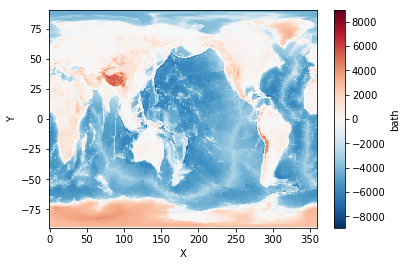

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

nc_url = "http://iridl.ldeo.columbia.edu/SOURCES/.WORLDBATH432/.bath/dods"
dsURL = xr.open_dataset(nc_url)
dsURL.bath.plot()

 - This is great, especially if URLs are short and simple
 - for anything more complicated we usually go to Data Library to generate  
 - the default web encoding makes a mess (e.g., normal, square and curly brackets )
```
    the simple code:
      SOURCES .WORLDBATH432 .bath
      Y (60S) (60N) RANGEEDGES   
      
    inserts a mess into the URL:
    ... SOURCES/.WORLDBATH432/.bath/Y/%2860S%29%2860N%29RANGEEDGES
    
    (actually this is no longer necessary and we could use:
    ... SOURCES/.WORLDBATH432/.bath/Y/(60S)/(60N)/RANGEEDGES)
```

### 2. type ingrid commands as if in expert mode and generate the URL
  - suppose you don't know how to find a linear trend in python yet ...

http://strega.ldeo.columbia.edu:81/CMIP5/.byScenario/.rcp85/.atmos/.mon/.ts/.CCSM4/.r1i1p1/.ts/dup/[T]detrend-bfl/sub/dup/T/last/VALUE/exch/T/first/VALUE/sub/(trend)rn/dods


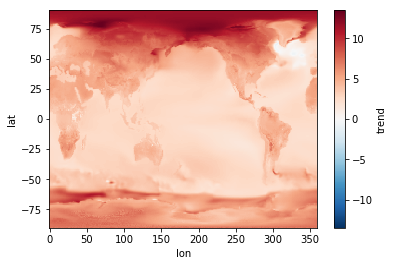

In [2]:
ingridsnippet = """
CMIP5 .byScenario .rcp85 .atmos .mon .ts .CCSM4 .r1i1p1 .ts
 dup [T]detrend-bfl sub
 dup T last VALUE exch T first VALUE sub 
(trend)rn
""" 

#now generate the URL, subsituting '/' for ' ':
sss = ' '.join(ingridsnippet.split()).replace(' ','/') #take out extra whitespaces first
nc_url2 = 'http://strega.ldeo.columbia.edu:81/'+sss+'/dods'
print(nc_url2)
xr.open_dataset(nc_url2).trend.plot()

### 3. write ingrid 'expert' code directly and pipe it to local ingrid executable
  - works only on byrd, kage, strega, snefru and many other local linux machines
  - allows you to save netcdf files and figures directly

In [3]:
from subprocess import Popen, PIPE

# generate a multiline string containing the ingrid commands:
ingridcode = """
\\begin{ingrid}
SOURCES .WORLDBATH432 .bath
(bath.nc)writeCDF 
%% /plotname (bath-from-notebook) def
%% X Y fig: colors coasts :fig .ps
\\end{ingrid}
""" 

# and then pipe it to the ingrid executable:
p = Popen(['/usr/local/bin/ingrid'], stdin=PIPE, stdout=PIPE) 
ingridout, ingriderr = p.communicate(input=bytes(ingridcode, 'utf-8'))

# now there will be the netcdf file, 'bath.nc' in your local directory
nc_file = 'bath.nc'
dsCODE = xr.open_dataset(nc_file)

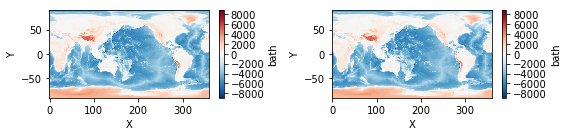

In [4]:
# to see that both give the same result:
plt.figure(figsize=(8,2))
plt.subplot(121)
dsURL.bath.plot()
plt.subplot(122)
dsCODE.bath.plot()
plt.tight_layout()

# and can check directly:
assert dsURL.equals(dsCODE)

### Variable substitution example (using my python module)

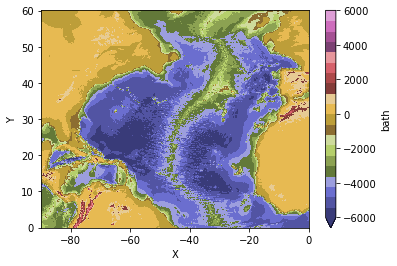

In [5]:
import sys
sys.path.append("/net/carney/home/naomi/mymodules")
from ingrid.code import callIngrid

# Ingrid comments should begin with %% to avoid misinterpretation
# Variable substitution can be done a couple of ways, here is one:
var = 'bath'
file = 'bath-another.nc'

ingridcode = """
\\begin{ingrid}
SOURCES .WORLDBATH .%s
Y 0 60 RANGE X (90W) (0W) RANGE
(%s)writeCDF 
%%X Y fig: colors :fig .ps
\\end{ingrid}
"""  %(var, file)

callIngrid(ingridcode)
xr.open_dataset(file).bath.plot(cmap='tab20b',vmin=-6000,vmax=6000)